## MNIST
Fetch MNIST dataset from OpenML.org

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", as_frame=False)

Observe the dataset.

In [3]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

After observing the dataset, there are 70,000 images consisting of 784 features each.

Grab an instance's feature vector, reshape it into a 28x28 array then display it using Matplotlib's imshow() function.

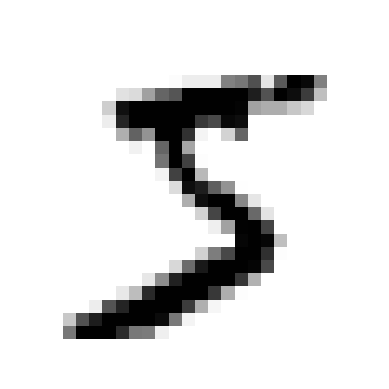

In [6]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap="binary") # Get a greyscale color map
  plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

Create a train-test set. Since the MNIST dataset comes pre-split into training and test sets, the training set consist of the first 60,000 images whereas the test set contains the rest of the images.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

**Classification Task:** Identify one digit e.g. having a "5-detector" which is capable to distinguish between two classes: 5 and non-5.

Create Target vectors for the classification task.

In [8]:
y_train_5 = (y_train == "5")
y_test_5 = (y_test == "5")

#### Stochastic Gradient Descent (SGD) Classifier

Create an SGD Classifier and train it on the training set.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Test the model's performance.

In [10]:
sgd_clf.predict([some_digit]) # some_digit == '5

array([ True])

## Performance Measures

### Measuring Accuracy using Cross-Validation
Use cross_val_score() function to evaluate the SGD Classifier model using 3-fold CV.

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Even though for all cross-validation folds the accuracy is above 95% accuracy, the dummy classifier which classifies every single image in the most frequent class should be tested.

In [12]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


Since "False" is printed, it indicates that no 5s were detected.

Check the Dummy Classifier model's accuracy.

In [13]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

All CV folds have above 90% accuracy, however it is because only about 10% of the dataset images are 5's.

Hence this proves that accuracy is not the preferred performance measure for classifiers, especially when dealing with skewed datasets (some classes appear more frequently than others_.

### Confusion Matrices

Before computing the confusion matrices, a set of predictions should be created.

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Computation of confusion matrix:

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

**True Positive:** 53,892   
**False Positive:** 687  
**False Negative:** 1,891  
**True Negative:** 3,530  

* A perfect classifier should only have true positives and true negatives and 0 false positive and negative.

### Precision and Recall

In [16]:
from sklearn.metrics import precision_score, recall_score

Precision Score

In [17]:
precision_score(y_train_5, y_train_pred) # Precision = TP / (TP+FP)

0.8370879772350012

Recall Score

In [18]:
recall_score(y_train_5, y_train_pred) # Recall = TP / (TP+FN)

0.6511713705958311

### F1 Score
Combination of Precision and Recall score.

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

### Example
**Low Recall, High Precision:** *Detect videos that are safe for kids.* <br>Rejects good videos (low recall) but keep only the safe ones (high precision)

**High Recall, Low Precision:** *Detect shoplifters* <br> Even though there would be many false alerts but, almost all shoplifters would be caught.

## Precision/Recall Trade-off

#### How SGD Classifier makes its classification decision:
* A score is computed based on a decision function
* If that score is greater than a threshold, the instance would be asssigned to the positive class, otherwise it will be assigned to the negative class
* The lower the threshold, the higher the recall and the lower the precision
* The higher the threshold, the lower the recall and the higher the precision

Decision scores (y-score) that is used to make predictions can be computed.

In [20]:
y_score = sgd_clf.decision_function([some_digit])
y_score

array([2164.22030239])

To decide on which threshold to use, use cross_val_predict function.

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

The Precision and Recall scores can be plotted against various threshold.

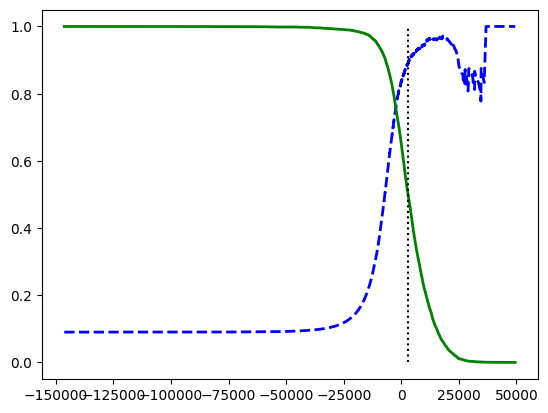

In [22]:
from sklearn.metrics import precision_recall_curve

threshold = 3000 # Set threshold to 3000
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

From the graph, it can be observed that when the threshold = 3000, the Precision is ~90% and Recall is ~50%.

Suppose a model which 90% precision is needed, the argmax() function can be used to return the first index of the value then the threshold can be derived.

In [23]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

Check the predictions' Precision and Recall:

In [24]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [25]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## ROC Curve

Similar to the Precision/Recall curve, the Receiver Operating Characteristic (ROC) curve is also used with binary classifiers. However, the ROC curve plots the True Positive Rate against the False Positive Rate.

In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

FPR can be plotted against TPR.  
In this case, to find the point corresponding to 90% precision, the index of the desired threshold has to be derived.  <br>Since the thresholds are listed in descending order, <= should be used instead of >=

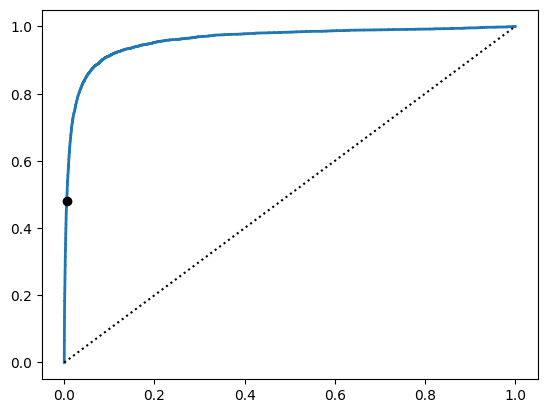

In [27]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
[...] # beautify the figure: add labels, grid, legend, arrow, and text
plt.show()

The higher the recall (TPR), the more false positives (FPR) the classifier produces.

To compare classifiers, Area Under Curve (AUC) can be computed. <br>
* A perfect classifier will have a ROC AUC equal to 1
* A purely random classifier will have a ROC AUC equal to 0.5

In [28]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Create a Random Forest Classifier whose Precision-Recall(PR) curve and F1 score can be compared to the SGD Classifier.

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

Predict class probabilities for every image.

In [30]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

Observe the class probabilities for the first 2 images.

In [31]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that:
* **First Image:** Positive with 89% probability
* **Second Image:** Negative with 99% probability

Plot the PR curve and compare the classifiers.

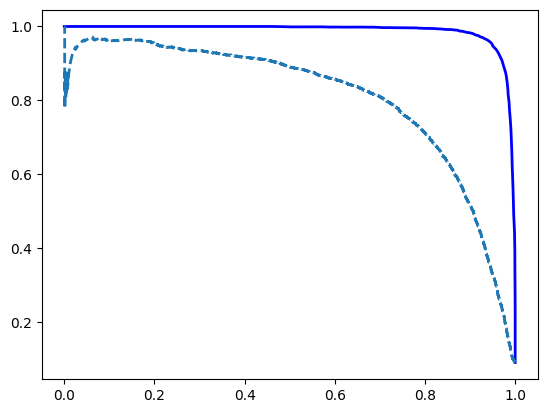

In [32]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
[...] # beautify the figure: add labels, grid, and legend
plt.show()

From the curve, the Random Forest Classifier (Solid Lines) looks better than the SGD Classifier (Dotted Lines)

Compute F1 score and ROC AUC of the Random Forest Classifier.

In [33]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

The F1 and ROC AUC score of Random Forest classifier are also significantly better than SGD classifier.

## Multiclass Classification

Whenever a binary classification algorithm is used for a multiclass classification task, Scikit-Learn will automatically run *one-versus-the-rest* (OVR) or *one-versus-one* (OVO) strategy.

In [35]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

Score of each class can be computed using the "decision_function()" method. Each class will get a score based on the number of wins.

In [36]:
some_digit_scores = svm_clf.decision_function([some_digit]) # some_digit = 5
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [37]:
class_id = some_digit_scores.argmax()
class_id

5

The highest score is 9.3 and corresponds to class 5.

It is also possible to force Scikit-Learn to use OVO or OVR using "OneVsOneClassifier" or "OneVsRestClassifier" classes.  

In [38]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

SGD Classifier can also be trained on a multiclass dataset:

In [39]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

Check the scores that the SGD Classifier assigned to each class.

In [40]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

From the results, it is evident that the classifier is not confident about its prediction since most of them are negative and class 5 is negative as well.  
Therefore, the "cross_val_score" function can be tried to evaluate the mode instead.

In [43]:
cross_val_score(sgd_clf, X_train, y_train, cv=2, scoring="accuracy")

array([0.8795    , 0.88853333])

Even though the model is already doing good since the accuracy are above 85% for all test folds, the model can be further improved by scaling the inputs.

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=2, scoring="accuracy")

array([0.90543333, 0.89936667])

## Error Analysis

To ensure that a promising model is found and wants to be further improved, it can be done by analyzing the types of error it makes.

Can try confusion matrix first. However, since there are 10 classes, the confusion matrix would be hard to read, hence a colored diagram of the confusion matrix could be used instead.

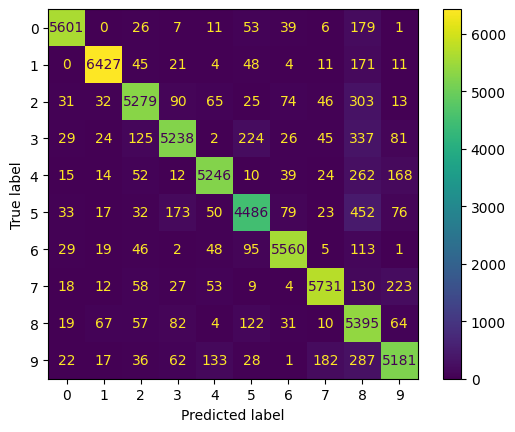

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=2)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

From the diagram, it can be deduced that the confusion matrix is pretty good since most images are on the main diagonal, meaning that they were classified correctly.

It is also very important to normalize the confusion matrix by diving each value by the total number of images in the corresponding class since in this case, there were fewer 5s in the dataset than other digits hence themodelmademore errors on 5s as seen from the darker cell in the diagram.

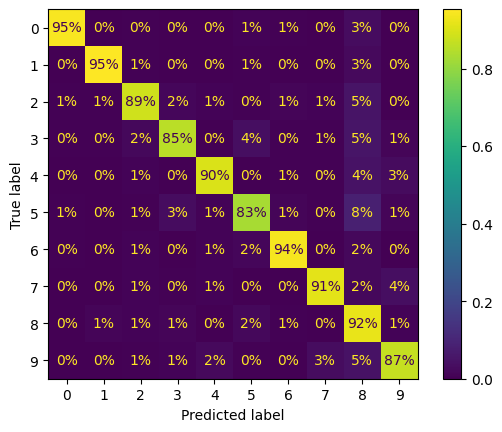

In [48]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%") # Normalize and show percentages without any decimals

* 82% of the images of 5s were classified correctly
* Most common error made with images of 5s: Being misclassified with 8s, this happened for 10% of all 5s  

To make the errors stand out more, zero weight can be placed on the correct predictions.

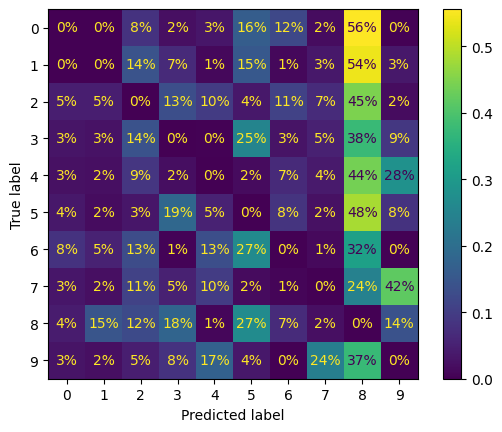

In [49]:
sample_weight = (y_train_pred!=y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%")

It can be observed that the column of class 8 is very bright, suggesting that many images got misclassified as 8s.